In [366]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import statsmodels.formula.api as smf

In [367]:
dfr=pd.read_csv('tempSiteRatings.csv')
dfd=pd.read_csv('tempUrlMetrics.csv')
dfd['rating']=dfr['rating']
dfd.to_csv('dataReg.csv')

In [368]:
data=pd.read_csv('dataReg.csv')
data.drop(['Unnamed: 0'],1, inplace=True)

In [369]:
def changeColName(data):
    try:
        columns=['word_count','body_text_percent','emphasized_text_percent','text_position_changes','text_cluster_count','link_count','page_size','graphic_percent','graphic_count','colour_count','font_count','colourfulness','visual_complexity','rating']
        data.columns=columns
    except:
        columns=['word_count','body_text_percent','emphasized_text_percent','text_position_changes','text_cluster_count','link_count','page_size','graphic_percent','graphic_count','colour_count','font_count','colourfulness','visual_complexity']
        data.columns=columns
    return data
def dropMetrics(data):
    try:
        data.drop(['id','url'],1, inplace=True)#,'p1','p2','p4','p6','p7','p10','p11','p12','p13'
    except:
        data.drop(['slno','url'],1, inplace=True)
    return data
def stdNormal(data,mean,std):
    x = data.values #returns a numpy array
    columns=data.columns
    x_scaled=(x-mean)/std
    data=pd.DataFrame(x_scaled,columns=columns)
    return data
def catCol(data,col):
    data[col+'_high']=np.zeros(data[col].shape)
    data[col+'_avg']=np.ones(data[col].shape)
    data[col+'_low']=np.zeros(data[col].shape)

    data[col+'_high'][np.where(data[col]>.431)[0]]=1.0
    data[col+'_avg'][np.where(data[col]>.431)[0]]=0.0
    data[col+'_avg'][np.where(data[col]<-.431)[0]]=0.0
    data[col+'_low'][np.where(data[col]<-.431)[0]]=1.0
    data.drop([col],1,inplace=True)
    return data
def catColPdf(data,col):
    import scipy.stats
    
    mean_high=np.mean(data[col][np.where(data[col]>.431)[0]])
    std_high=np.std(data[col][np.where(data[col]>.431)[0]])


    mean_avg=np.mean(data[col][np.where(abs(data[col])<.431)[0]])
    std_avg=np.std(data[col][np.where(abs(data[col])<.431)[0]])

    mean_low=np.mean(data[col][np.where(data[col]<-.431)[0]])
    std_low=np.std(data[col][np.where(data[col]<-.431)[0]])

    data[col+'_high']=scipy.stats.norm(mean_high,std_high).pdf(data[col].values)
    data[col+'_avg']=scipy.stats.norm(mean_avg,std_avg).pdf(data[col].values)
    data[col+'_low']=scipy.stats.norm(mean_low,std_low).pdf(data[col].values)
    
    data.drop([col],1,inplace=True)
    
    return data
def preProcess(data,mean,std):
    data=changeColName(data)
    try:
        rating=data['rating']
        data.drop(['rating'],1,inplace=True)
    except:
        pass
    data=stdNormal(data,mean,std)
    data=catCol(data,'word_count')
    data=catCol(data,'page_size') 
    data=catCol(data,'colourfulness') 
    data=catCol(data,'visual_complexity') 
    try:
        data['rating']=rating
    except:
        pass
    return data

In [370]:
ids=data['slno']
data=dropMetrics(data)

In [371]:
mean=np.mean(data.values[:,:-1],axis=0)
std=np.std(data.values[:,:-1],axis=0)


In [372]:
data=preProcess(data,mean,std)
irrCol=['emphasized_text_percent','font_count']
data.drop(irrCol,1,inplace=True)

/home/abhiavk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


In [373]:
correlation = data.corr(method='pearson')
columns = correlation.nlargest(30,'rating').index
columns

Index(['rating', 'word_count_avg', 'colourfulness_low', 'graphic_count',
       'page_size_high', 'page_size_avg', 'body_text_percent',
       'graphic_percent', 'visual_complexity_low', 'visual_complexity_high',
       'visual_complexity_avg', 'colour_count', 'link_count',
       'text_position_changes', 'colourfulness_high', 'colourfulness_avg',
       'word_count_low', 'word_count_high', 'text_cluster_count',
       'page_size_low'],
      dtype='object')

In [374]:
def corr():
    fig, ax = plt.subplots(figsize=(30,30))    
    correlation_map = np.corrcoef(data[columns].values.T)
    sns.set(font_scale=2.4)
    heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, annot_kws={"size": 30},square=True, fmt='.2f',yticklabels=columns.values, xticklabels=columns.values)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 50
    plt.savefig('corr')

In [375]:
columns=columns.tolist()
columns.sort()
columns=pd.Index(columns)
columns=columns.drop('rating')

In [377]:
Y=data['rating'].values
X=data[columns].values

In [378]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True,test_size=0.3, random_state=1)

def LinearReg():
    from sklearn.linear_model import LinearRegression
    reg =LinearRegression()
    return reg
def RidgeReg():
    from sklearn.linear_model import Ridge
    reg =Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,normalize=False, random_state=1, solver='svd', tol=0.001)
    return reg
def MLPReg():
    from sklearn.neural_network import MLPRegressor
    reg=MLPRegressor(hidden_layer_sizes=(23,),activation='logistic',solver='adam', max_iter=10000,batch_size=10,alpha=0.01)
    return reg
def KNNReg():
    from sklearn.neighbors import KNeighborsRegressor
    reg=KNeighborsRegressor(n_neighbors=5,algorithm='brute',metric='manhattan')
    return reg
def RMS_test(reg):
    from sklearn.metrics import mean_squared_error
    Y_pred=reg.predict(X_test)
    return Y_pred,mean_squared_error(Y_test, Y_pred)
def RMS_train(reg):
    from sklearn.metrics import mean_squared_error
    Y_pred=reg.predict(X_train)
    return Y_pred,mean_squared_error(Y_train, Y_pred)
def RMS(reg):
    from sklearn.metrics import mean_squared_error
    Y_pred=reg.predict(X)
    return Y_pred,mean_squared_error(Y, Y_pred)
def getRMS(reg):
    print(RMS_test(reg)[1],RMS_train(reg)[1])
def getRV(reg):
    Y_pred=RMS_test(reg)[0]
    Y_pred=RMS(reg)[0]
    rsq=np.sum((Y_pred-np.mean(Y_pred))**2)/np.sum((Y-np.mean(Y))**2)
    N,p=X.shape
    adjRsq=1-((1-rsq)*(N-1)/(N-p-1))
    print(rsq,adjRsq)

In [379]:
regLinear=LinearReg()
regLinear.fit(X_train,Y_train)

regRidge=RidgeReg()
regRidge.fit(X_train,Y_train)

regMLP=MLPReg()
regMLP.fit(X_train,Y_train)

regKNN=KNNReg()
regKNN.fit(X_train,Y_train)

temp=0

In [380]:
regLinear.intercept_,regLinear.coef_,columns

(4.079409161998166,
 array([-0.06122946,  0.05310072, -0.16901776,  0.08623467,  0.08278309,
         0.25844812, -0.12353413, -0.08870703,  0.24535606,  0.83338738,
        -1.07874344, -0.16206067, -0.1361118 , -0.18610132,  0.15487317,
         0.03122816,  0.37032936, -0.25493173, -0.11539763]),
 Index(['body_text_percent', 'colour_count', 'colourfulness_avg',
        'colourfulness_high', 'colourfulness_low', 'graphic_count',
        'graphic_percent', 'link_count', 'page_size_avg', 'page_size_high',
        'page_size_low', 'text_cluster_count', 'text_position_changes',
        'visual_complexity_avg', 'visual_complexity_high',
        'visual_complexity_low', 'word_count_avg', 'word_count_high',
        'word_count_low'],
       dtype='object'))

In [327]:
getRMS(regLinear)
getRMS(regRidge)
getRMS(regMLP)
getRMS(regKNN)

0.8244547791465306 0.4550063551423562
0.7921293832493563 0.4602724245133801
0.6858168783852767 0.1706546696644292
0.8474273231200308 0.48182256787147865


In [328]:
getRV(regLinear)
getRV(regRidge)
getRV(regMLP)
getRV(regKNN)

0.3926753208134155 0.2367406058871303
0.319319213673936 0.14454982259021687
0.5651656368829034 0.45351897608256786
0.1442937546246311 -0.07541460567445002


In [313]:
regLinear=LinearReg()
regLinear.fit(X,Y)
getRMS(regLinear)

0.5282990418788357 0.5039054872257691


In [310]:
Y_total_Pred=regMLP.predict(X)
import scipy.stats as stats
from sklearn import feature_selection
stats.f_oneway(Y_total_Pred,Y)
feature_selection.f_regression(X,Y)


(array([4.24562479e+00, 2.98060153e+00, 2.68325358e+00, 1.52132617e+00,
        3.85409868e-01, 1.81509710e-01, 5.98173690e-02, 2.09500214e-02,
        1.29857959e-03, 3.05309742e-02, 8.44860900e-02, 2.83942542e-01,
        5.02938911e-01, 7.69513922e-01, 8.44385708e-01, 1.27476968e+00,
        1.94745298e+00, 2.89436251e+00, 8.50205127e+00]),
 array([0.0421751 , 0.08762456, 0.10482421, 0.22056094, 0.53625711,
        0.67107413, 0.80732949, 0.88523181, 0.97133188, 0.86167485,
        0.77196183, 0.5954135 , 0.480005  , 0.38265244, 0.36054841,
        0.26180923, 0.16622081, 0.0922675 , 0.00445571]))

In [275]:
try:
    print(regLinear.coef_)
    print(regLinear.intercept_)
except: 
    pass

[ 0.31938717  0.08540708  0.28351828  0.67708064  0.26509127 -0.0484363
 -0.04507594 -0.0957299   0.08618072  0.00954917 -0.11096567 -0.0858187
 -0.13099741  0.02212071 -0.10752779  0.05159313 -0.3709803  -0.20395379
 -0.94217191]
4.0730455252629705


In [178]:
def rateCountry(reg,regName):
    df={}
    irrCol=['emphasized_text_percent','font_count']
    country=['India','Usa']
    countryIdUrl=[0,0]
    ind=-1
    for year in country:
        ind+=1
        df[str(year)]=pd.read_csv('yearMetrics/tempUrlMetrics'+str(year)+'.csv')
        countryIdUrl[ind]=df[str(year)][['slno','url']]
        df[str(year)]=dropMetrics(df[str(year)])
        df[str(year)]=preProcess(df[str(year)],mean,std)
        df[str(year)].drop(irrCol,1,inplace=True)
    meanYears=np.zeros(2)
    stdYears=np.zeros(2)
    ind=-1
    countryRating=[0,0]
    for year in country:
        ind+=1
        countryRating[ind]=reg.predict(df[str(year)][columns].values)
    x =countryRating[0]
    m=max(x)
    interval=None
    interval=[0,6]
    num_bins = 100
    fig, ax = plt.subplots(figsize=(20,12))
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 36
    plt.xlabel("Rating")
    plt.ylabel(" Number of Indian Sites")
    n, bins, patches = plt.hist(x,num_bins, range=interval,facecolor='blue', alpha=0.5)
    plt.savefig("histIndia"+regName)
    plt.show()
    x =countryRating[1]
    m=max(x)
    interval=None
    interval=[0,6]
    num_bins = 100
    fig, ax = plt.subplots(figsize=(20,12))
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 36
    plt.xlabel("Rating")
    plt.ylabel(" Number of Usa Sites")
    n, bins, patches = plt.hist(x,num_bins, range=interval,facecolor='blue', alpha=0.5)
    plt.savefig("histUsa"+regName)
    plt.show()

In [179]:
def showEvolution(reg,regName):
    df={}
    irrCol=['emphasized_text_percent','font_count']
    for year in range(2000,2020):
        df[str(year)]=pd.read_csv('yearMetrics/tempMpUrlMetrics'+str(year)+'.csv')
        df[str(year)]=dropMetrics(df[str(year)])
        df[str(year)]=preProcess(df[str(year)],mean,std)
        df[str(year)].drop(irrCol,1,inplace=True)
    meanYears=np.zeros(20)
    stdYears=np.zeros(20)
    for year in range(2000,2020):
        meanYears[year-2000]=np.mean(reg.predict(df[str(year)][columns].values))
        stdYears[year-2000]=np.std(reg.predict(df[str(year)][columns].values))
    fig, ax = plt.subplots(figsize=(6,6))
    x=range(2000,2020)
    y=meanYears
    e=stdYears*0
    plt.errorbar(x, y, e, fmt='-o')
    plt.xticks(np.arange(min(x), max(x)+1, 5))
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 16
    plt.ylabel('Website rating')
    plt.xlabel('Year')
    plt.savefig('modelReg'+regName)

/home/abhiavk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/home/abhiavk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/abhiavk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/home/abhiavk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/abhiavk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/home/abhiavk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/abhiavk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/home/abhiavk/anaconda3/lib/python3.6/site-packages

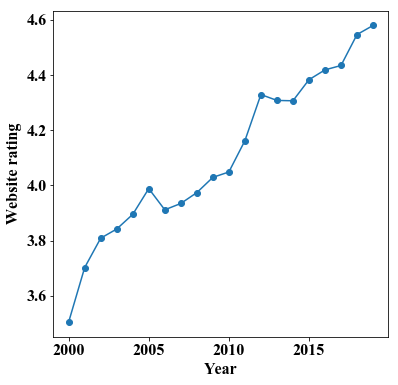

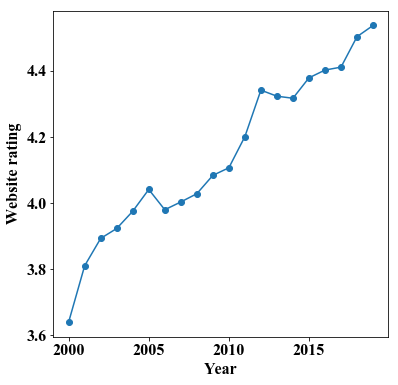

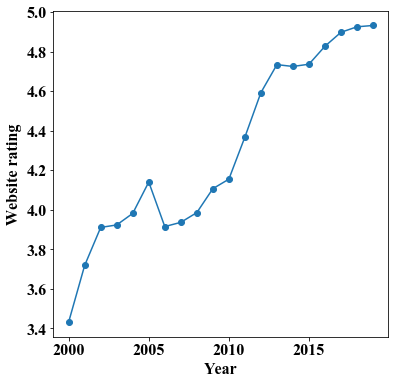

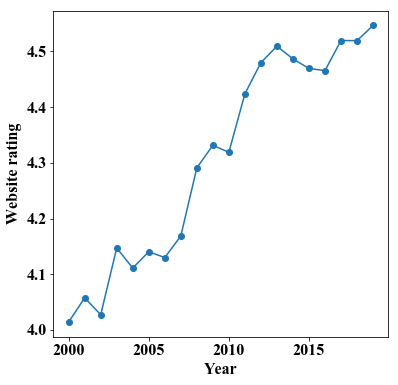

In [105]:
showEvolution(regLinear,"Linear")
showEvolution(regRidge,"Ridge")
showEvolution(regMLP,"MLP")
showEvolution(regKNN,"KNN")

/home/abhiavk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/home/abhiavk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


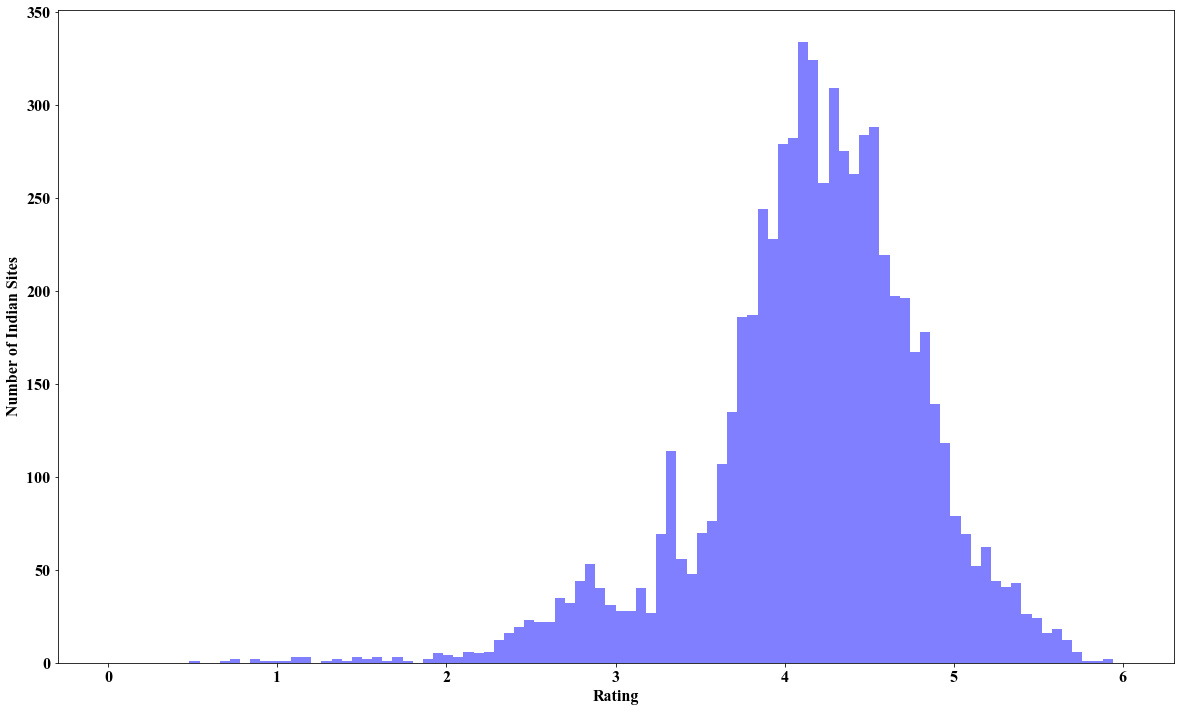

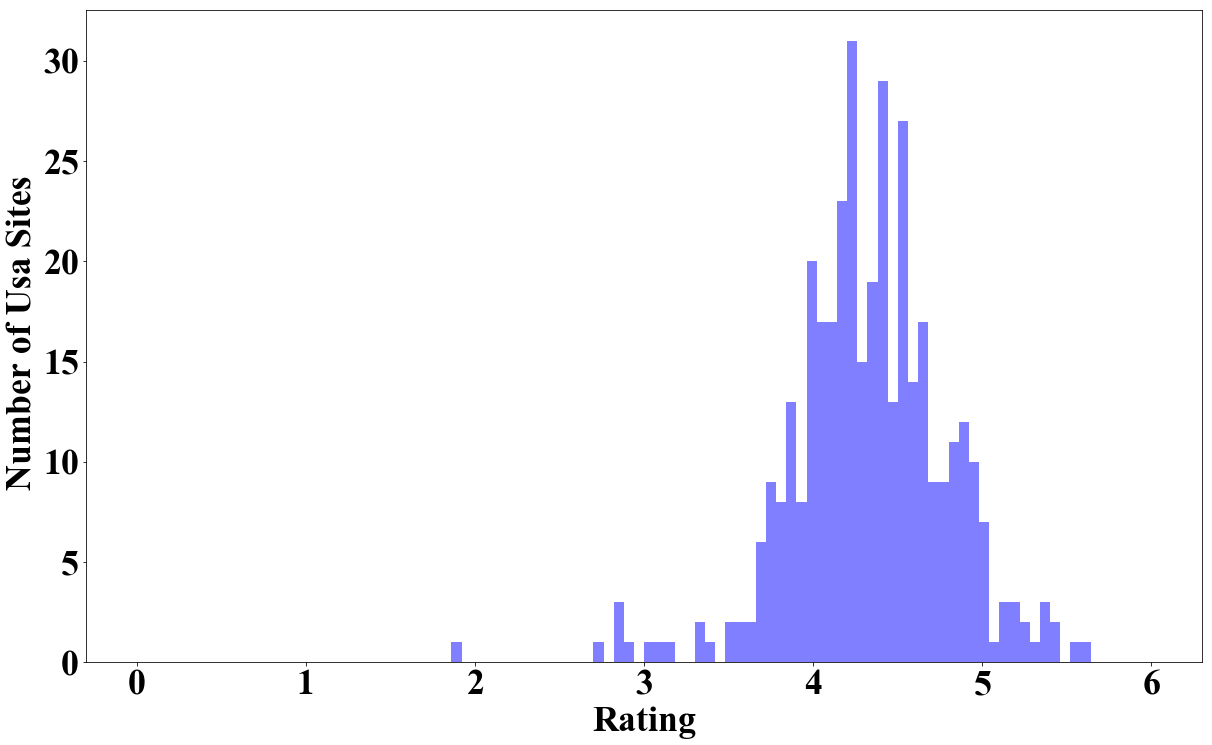

/home/abhiavk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/home/abhiavk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


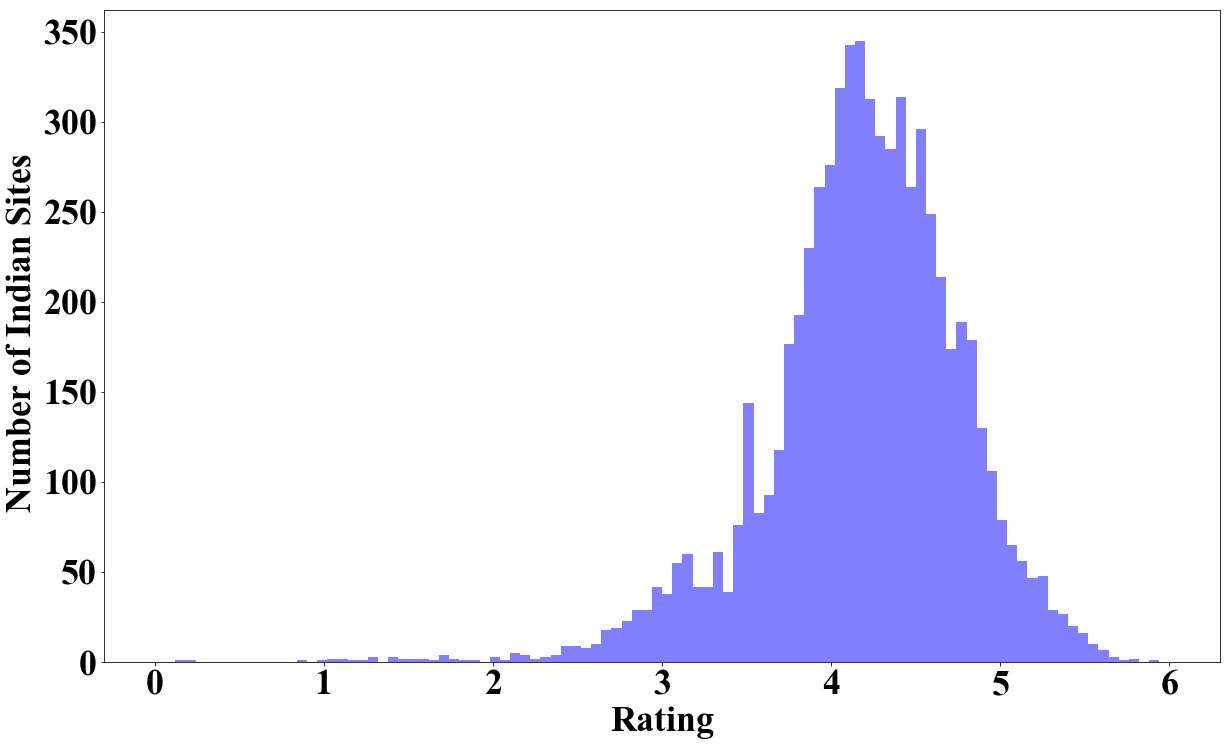

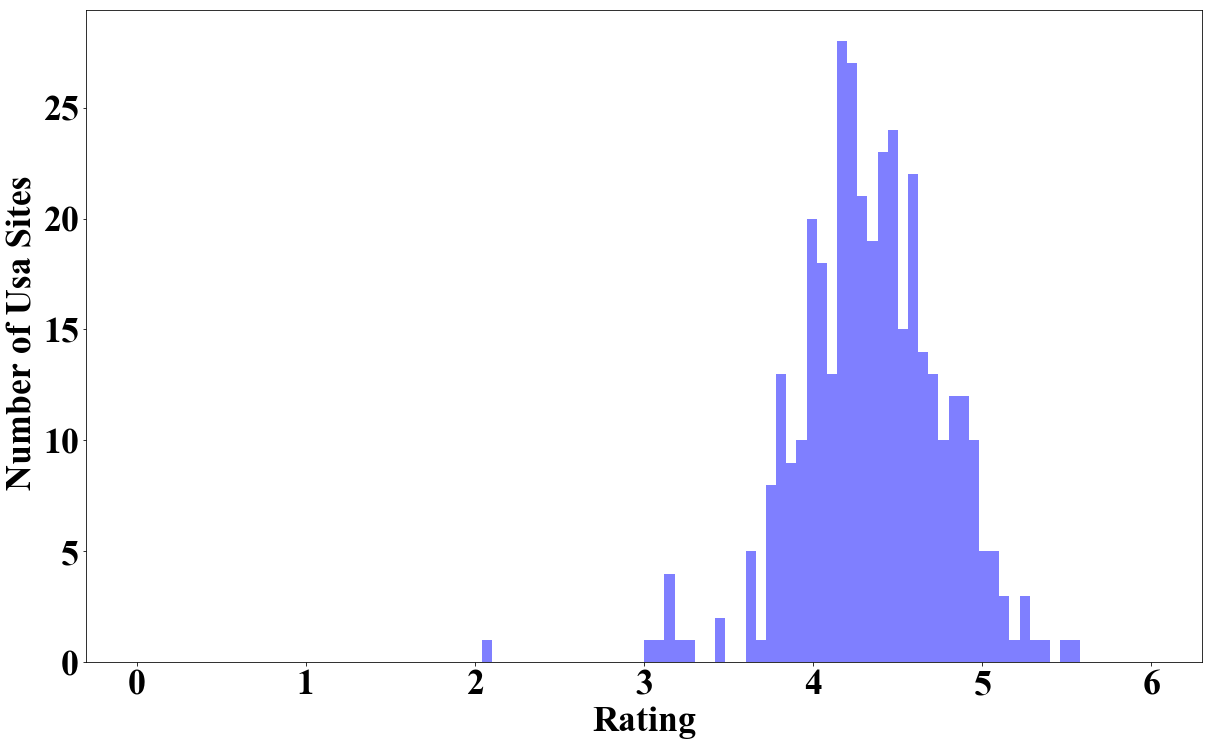

/home/abhiavk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/home/abhiavk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


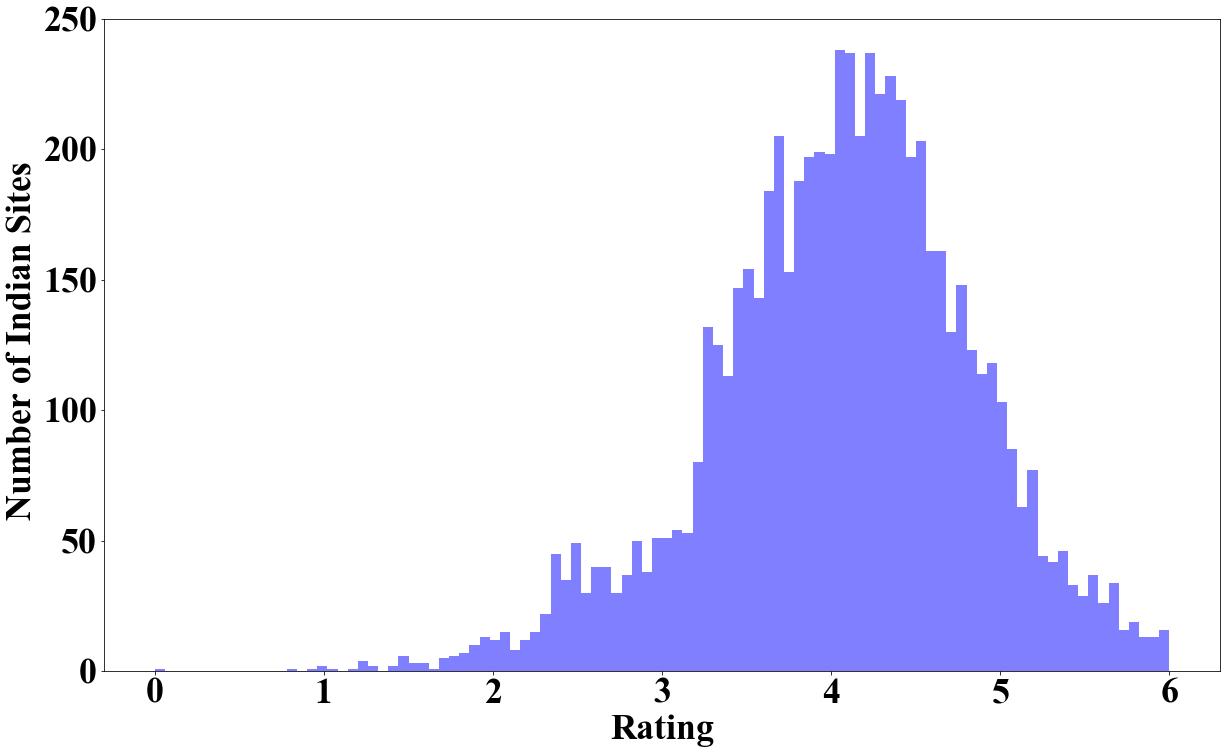

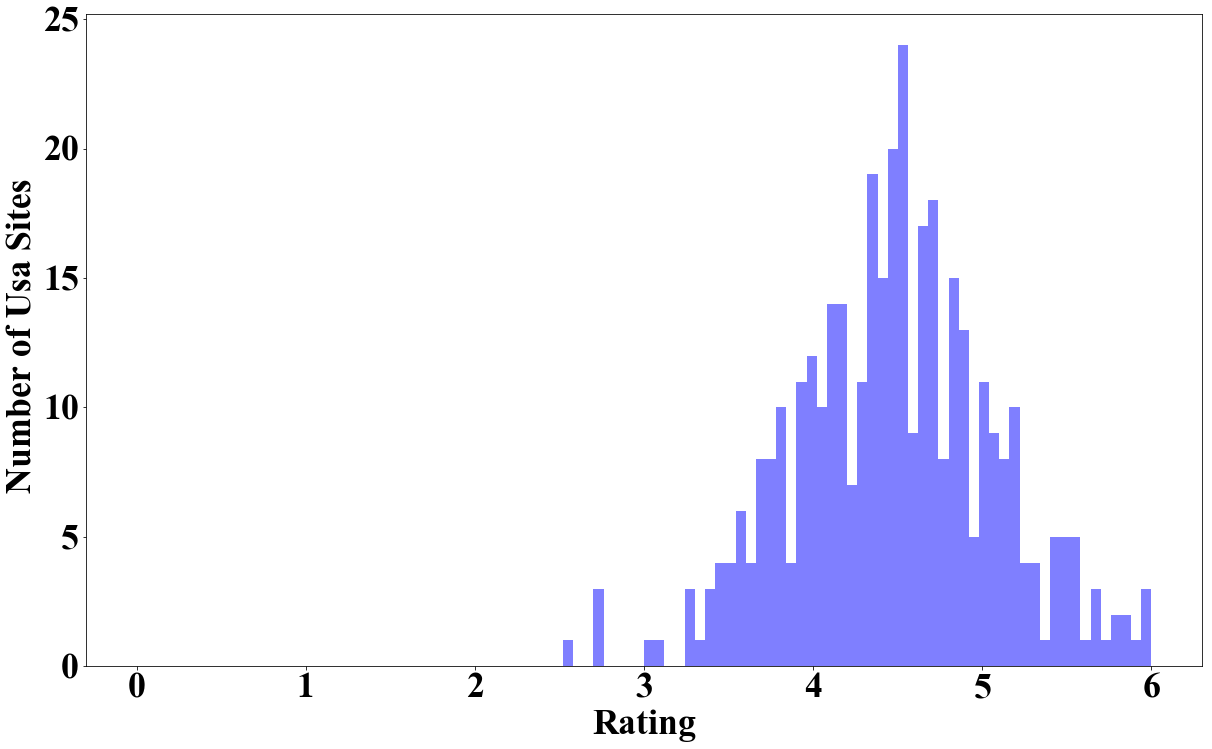

/home/abhiavk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/home/abhiavk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


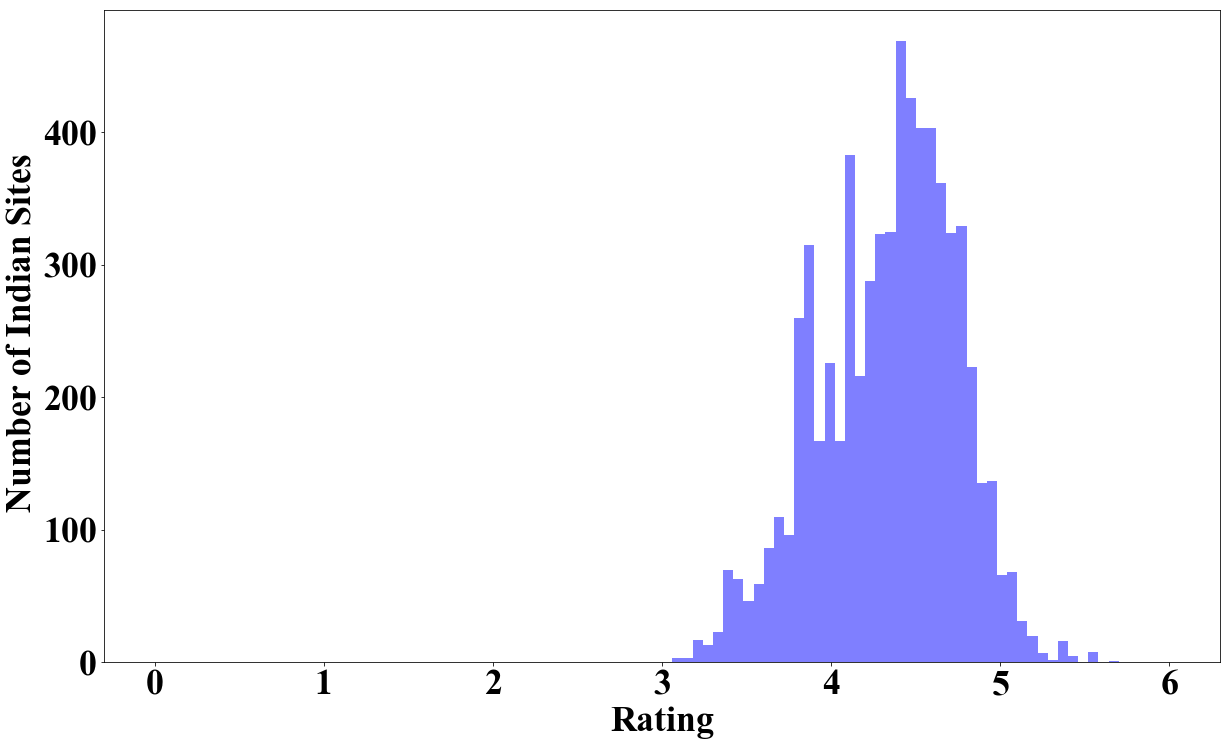

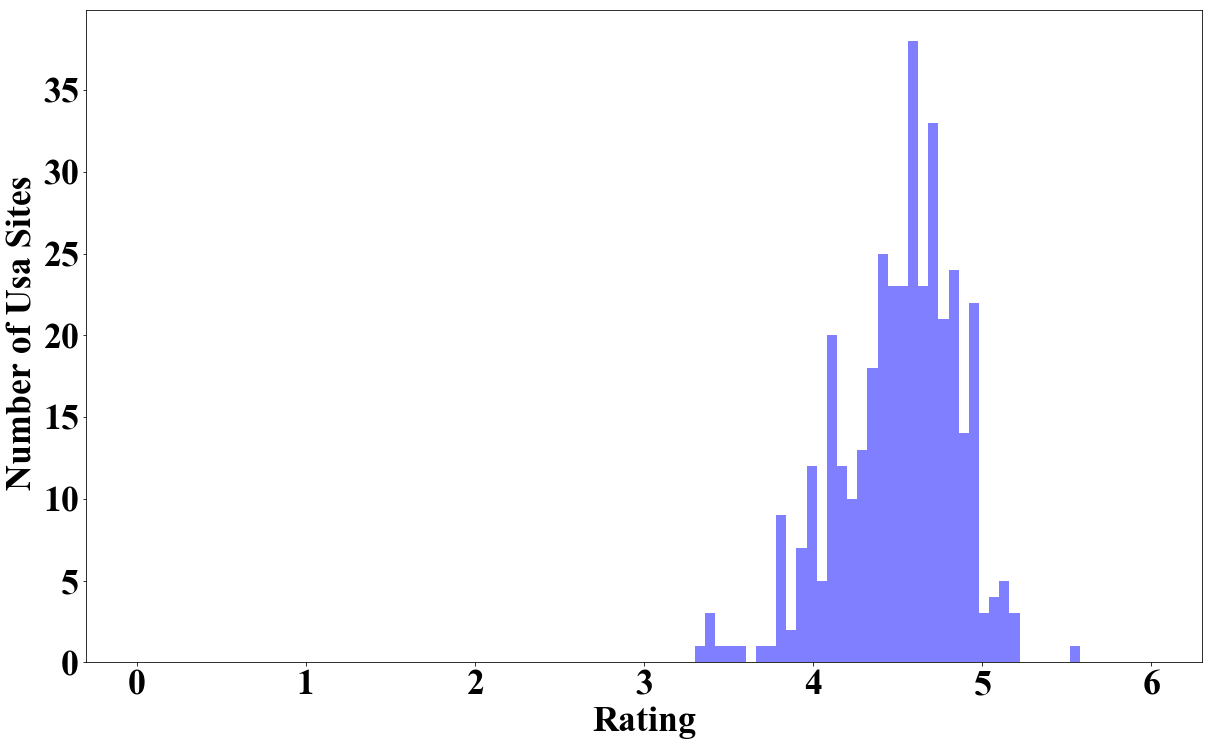

In [111]:
rateCountry(regLinear,"Linear")
rateCountry(regRidge,"Ridge")
rateCountry(regMLP,"MLP")
rateCountry(regKNN,"KNN")

In [180]:
df={}
irrCol=['emphasized_text_percent','font_count']
country=['India','Usa']
countryIdUrl=[0,0]
ind=-1
for year in country:
    ind+=1
    df[str(year)]=pd.read_csv('yearMetrics/tempUrlMetrics'+str(year)+'.csv')
    countryIdUrl[ind]=df[str(year)][['slno','url']]
    df[str(year)]=dropMetrics(df[str(year)])
    df[str(year)]=preProcess(df[str(year)],mean,std)
    df[str(year)].drop(irrCol,1,inplace=True)
meanYears=np.zeros(2)
stdYears=np.zeros(2)
ind=-1
countryRating=[0,0]
for year in country:
    ind+=1
    countryRating[ind]=regLinear.predict(df[str(year)][columns].values)

/home/abhiavk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/home/abhiavk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


In [181]:
countryRating[1].shape

(379,)

In [182]:
countryIdUrl[1].shape

(379, 2)

In [184]:
np.where(countryRating[1]<3)[0]

array([110, 144, 156, 248, 298, 347])

In [260]:
ind=np.where(countryRating[0]>5)[0]
Iind=412

print(countryIdUrl[0].values[ind][Iind])
print(countryRating[0][ind][Iind])

[8017 'http://www.pred.gov.in']
5.199018363962491


In [216]:
ind=np.where(countryRating[0]<3)[0]
Iind=95
print(countryIdUrl[0].values[ind][Iind])
print(countryRating[0][ind][Iind])

[2503 'http://jksrc.nic.in']
2.4848821118775097


In [261]:
ind=np.where(countryRating[1]>5)[0]
Iind=13
print(countryIdUrl[1].values[ind])
print(countryRating[1][ind])

[[1 'http://acus.gov']
 [31 'http://www.afrc.af.mil']
 [37 'http://www.amtrak.com']
 [67 'http://www.cfo.gov']
 [84 'http://www.csb.gov']
 [107 'http://www.dpaa.mil/Home.aspx']
 [109 'http://www.dss.mil']
 [131 'http://www.fanniemae.com']
 [141 'http://www.federallabs.org']
 [174 'http://www.gsa.gov']
 [200 'http://www.loc.gov']
 [256 'http://www.oge.gov']
 [267 'http://www.peacecorps.gov']
 [282 'http://www.si.edu']
 [289 'http://www.state.gov']
 [328 'http://www.ushmm.org']
 [332 'http://www.usmc.mil']
 [338 'http://www.usuhs.mil']
 [375 'https://www.energy.gov/em/office-environmental-management']
 [378 'https://www.energy.gov/ne/office-nuclear-energy']
 [400 'https://www.jpeocbd.osd.mil/home']
 [419 'https://www.usbr.gov']]
[5.34497834 5.63008516 5.1642752  5.44446504 5.15289972 5.02456634
 5.1755739  5.26501435 5.13830087 5.00795    5.34890812 5.20882235
 5.03841117 5.2515205  5.14688324 5.02841429 5.28708076 5.44901576
 5.02151163 5.35906505 5.56718713 5.0896303 ]


In [193]:
ind=np.where(countryRating[1]<3)[0]
print(countryIdUrl[1].values[ind])
print(countryRating[1][ind])

[[126 'http://www.eric.ed.gov']
 [164 'http://www.fs.fed.us/ficmnew/index.shtml']
 [178 'http://www.house.gov']
 [281 'http://www.senate.gov']
 [336 'http://www.ustda.gov']
 [398 'https://www.inaugural.senate.gov']]
[2.87668781 2.74886363 1.86947538 2.84975137 2.89617178 2.85520313]
